<a href="https://colab.research.google.com/github/VanishingPizza/GenAI/blob/main/HW1/Distilgpt2_Stress_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install & import the needed libraries

!pip install -q transformers torch

!pip install triton torchao

In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import os
os.environ["TQDM_DISABLE"] = "1" # Disables progress bar widgets error caused by GPT

In [ ]:
# Load tokenizer & model

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.eval()

In [ ]:
# Enter your own input text

text = input("Enter a sentence: ")

In [ ]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")

In [ ]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)

In [ ]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)

In [ ]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)

In [ ]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")

In [ ]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=1.2, top_k=50):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)

next_token_id = sample_next_token(logits, temperature=0.8, top_k=40)
print("Sampled token:", tokenizer.decode(next_token_id[0]))

In [ ]:
# Full loop (generate multiple tokens)

def generate_step_by_step(prompt, steps=20):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=0.1, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=20)

# Experiments

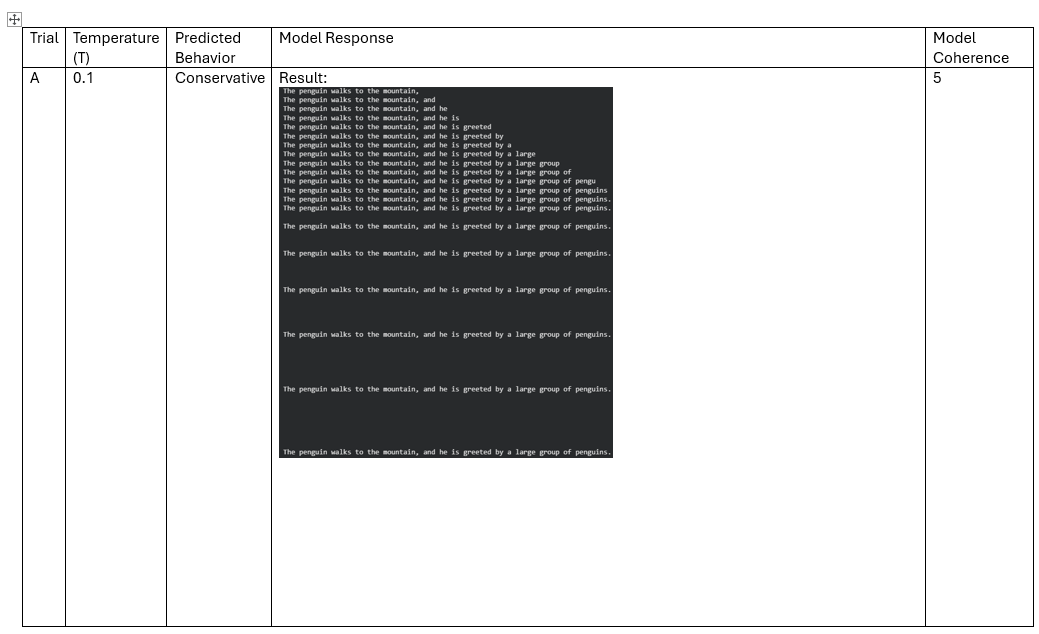

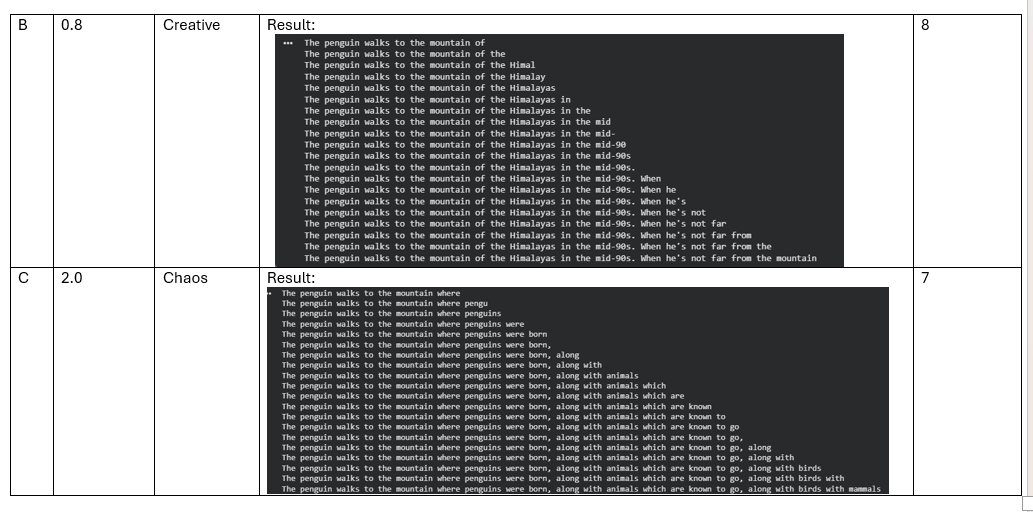

# Comparison to GPT-2

In experiment A, the output from the distilgpt2 model is almost similar to the gpt2 model. However in the distilgpt2 model, at a certain point it only repeats the last token which creates a new line.  